In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import glob
import time
import scipy.misc
import scipy.ndimage
from PIL import Image 
import cv2
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Define SRCNN

In [2]:
batch_size = 64
img_size = 33
channel_size = 3
label_size = 21
learning_rate = 1e-4
dataset_dir = 'C:/Users/qws/Documents/GitHub/Spring2019-Proj3-grp2/data/train_set/LR_1'
testset_dir = 'C:/Users/qws/Documents/GitHub/Spring2019-Proj3-grp2/data/train_set/HR_1'
sample_dir = 'C:/Users/qws/Documents/GitHub/Spring2019-Proj3-grp2/data/train_set/sample'
epochs = 40
scale = 3
stride = 14 
padding = 6
save_model_name = "SRCNN.model"
checkpoint_dir = "checkpoints"



weights = {
    'w1':tf.Variable(tf.random_normal([9,9,channel_size,64], stddev=1e-3),name='w1'),
    'w2':tf.Variable(tf.random_normal([1,1,64,32], stddev=1e-3), name='w2'),
    'w3':tf.Variable(tf.random_normal([5,5,32,channel_size], stddev=1e-3), name='w3')
}

bias = {
    'b1':tf.Variable(tf.zeros([64]),name='b1'),
    'b2':tf.Variable(tf.zeros([32]), name='b2'),
    'b3':tf.Variable(tf.zeros([channel_size]), name='b3')
}

inputs = tf.placeholder(tf.float32,[None,img_size, img_size,channel_size],name='inputs')
labels = tf.placeholder(tf.float32,[None,label_size,label_size,channel_size],name='labels')



conv1 = tf.nn.relu(tf.nn.conv2d(inputs,weights['w1'],strides=[1,1,1,1],padding='VALID')+bias['b1'])
conv2 = tf.nn.relu(tf.nn.conv2d(conv1,weights['w2'],strides=[1,1,1,1],padding='VALID')+bias['b2'])
conv3 = tf.nn.relu(tf.nn.conv2d(conv2,weights['w3'],strides=[1,1,1,1],padding='VALID')+bias['b3'])

pred=conv3
loss = tf.reduce_mean(tf.square(labels-conv3))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.


Read data and define prepocess

In [71]:
def read_data(train_dir,stride):
    # get data
    filenames = os.listdir(train_dir)
    data_dir = os.path.join(os.getcwd(), train_dir)
    data = glob.glob(os.path.join(data_dir, "*.jpg"))
    sub_input_sequence = []
    sub_label_sequence = []
    sub_input_nx=[]
    sub_input_ny=[]

    for idx in range(len(data)):
        input_, label_ = load_data(data[idx], scale)
        h, w,c = input_.shape
        nx=0
        ny=0
        for x in range(0, h - img_size + 1, stride):
            nx+=1
            ny=0
            for y in range(0, w - img_size + 1, stride):
                # print(x,x + img_size)
                ny+=1
                sub_input = input_[x:x + img_size, y:y + img_size]  
                sub_label = label_[x + padding:x + padding + label_size,
                            y + padding:y + padding + label_size]  

                sub_input = sub_input.reshape([img_size, img_size, channel_size])
                sub_label = sub_label.reshape([label_size, label_size, channel_size])

                sub_input_sequence.append(sub_input)
                sub_label_sequence.append(sub_label)

        sub_input_nx.append(nx)
        sub_input_ny.append(ny)
    return sub_input_sequence, sub_label_sequence,sub_input_nx,sub_input_ny


def load_data(data_path, scale=3):
    img = cv2.imread(data_path)
#     img = scipy.misc.imread(data_path, flatten=True, mode='YCbCr').astype(np.float)
    label_ = modcrop(img, scale=3)  #
    img = img / 255.
    label_ = label_ / 255.
    input_ = scipy.ndimage.interpolation.zoom(label_, (1. / scale), prefilter=False)
    input_ = scipy.ndimage.interpolation.zoom(input_, (scale / 1.), prefilter=False)
#     bicbuic_img = cv2.resize(label_,None,fx = 1.0/scale ,fy = 1.0/scale, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
#     input_ = cv2.resize(bicbuic_img,None,fx = scale ,fy=scale, interpolation = cv2.INTER_CUBIC)# Resize by scaling factor
    return input_, label_


def modcrop(image, scale=3):
    """
    To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
    """
    if len(image.shape) == 3:
        h, w, _ = image.shape
#         h = h - np.mod(h, scale)
#         w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image



def merge(images, size, c_dim):
    """
        images is the sub image set, merge it
    """
    h, w = images.shape[1], images.shape[2]
    
    img = np.zeros((h*size[0], w*size[1], c_dim))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j * h : j * h + h,i * w : i * w + w, :] = image
        #cv2.imshow("srimg",img)
        #cv2.waitKey(0)
        
    return img
  
# def array_image_save(array, image_path):
#   """
#   Converts np array to image and saves it
#   """
#   image = Image.fromarray(array)
#   if image.mode != 'RGB':
#     image = image.convert('RGB')
#   image.save(image_path)
#   print("Saved image: {}".format(image_path))

In [72]:
train_data, train_label, nx,ny = read_data(dataset_dir,stride)

C:\Anaconda\lib\site-packages\scipy\ndimage\interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [73]:
np.shape(train_data)

(11593, 33, 33, 3)

Training

In [40]:
print("Start training......")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        start_time = time.time()
        batch_idxs = len(train_data)//batch_size
        epoch_error = []
        for idx in range(batch_idxs):
            batch_images = train_data[idx*batch_size:(idx+1)*batch_size]
            # print(batch_images.shape)
            batch_labels = train_label[idx*batch_size:(idx+1)*batch_size]
            _, batch_loss,batch_conv3 = sess.run([train_op,loss,conv3],feed_dict={inputs:batch_images,labels:batch_labels})
            epoch_error.append(batch_loss)
            '''
            if idx %10 == 0:
                print("Epoch: [%d], batch: [%d], loss: [%f]" % (epoch,idx,batch_loss))
            '''
           
        if epoch % 10 == 0:
            print("Epoch: [%d], Time: [%4.2f], Loss: [%f]" % (epoch,time.time()-start_time,np.mean(epoch_error)))
            
    
    print("Start testing......")
    test_data, test_label, nx, ny = read_data(testset_dir, stride=21)
    _, test_conv3 = sess.run([train_op, conv3],
                             feed_dict={inputs: test_data, labels: test_label})
    filenames = os.listdir(testset_dir)
    data_dir = os.path.join(os.getcwd(), testset_dir)
    data = glob.glob(os.path.join(data_dir, "*.jpg"))
    for idx in range(len(data)):
        test_input_, test_label_ = load_data(data[idx], scale)
        result = merge(test_conv3[0:nx[idx]*ny[idx]], [nx[idx], ny[idx]],3)
        test_conv3 = test_conv3[nx[idx]*ny[idx]:]
#         result = result.squeeze()  # to squeeze to one channel


#         plt.figure(figsize=(20,20))
#         plt.subplot(1,3,1)
#         plt.imshow(test_input_)
#         plt.title("Input")
#         plt.subplot(1,3,2)
#         plt.imshow(result)
#         plt.title("Output")
#         plt.subplot(1,3,3)
#         plt.imshow(test_label_)
#         plt.title("Label")
#         plt.show()
        num=idx+1
        image_path = os.path.join(os.getcwd(), sample_dir)
        image_path = os.path.join(image_path, "test_image_%d_output.jpg" % num)
        cv2.imwrite(image_path, test_label_ * 255.)  # imwrite range(0,255)


    print("Start saving......")
    saver = tf.train.Saver()
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver.save(sess, os.path.join(checkpoint_dir, save_model_name))
    print("Finish!")

Start training......
Epoch: [0], Time: [1.68], Loss: [0.335189]
Epoch: [10], Time: [0.88], Loss: [0.299869]
Epoch: [20], Time: [0.89], Loss: [0.129651]
Epoch: [30], Time: [0.87], Loss: [0.129305]
Start testing......
Start saving......
Finish!


PSNR

In [55]:
image_dir = os.path.join(os.getcwd(), sample_dir)
sample = glob.glob(os.path.join(image_dir, "*.jpg"))

In [67]:
def MSE(img1,img2):
    temp = (img1 - img2)**2
    return sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])

def psnr(img1,img2):
    temp = (img1-img2)**2
    mse = sum(temp.reshape(-1))/(temp.shape[0]*temp.shape[1]*temp.shape[2])
    MAXI = 255
    return 20*math.log10(MAXI)-10*math.log10(mse)

psnr_out=[]
for i in range(len(data)):
  psnr_out.append(psnr(cv2.imread(data[i]),cv2.imread(sample[i])))
mean(psnr_out)

50.93413562060154

Super Resolution

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


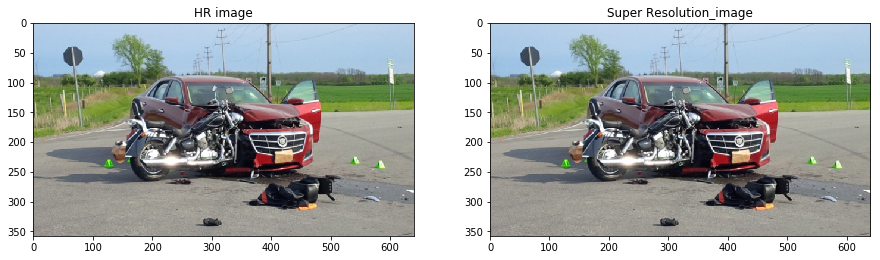

In [52]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('C:/Users/qws/Documents/GitHub/Spring2019-Proj3-grp2/data/train_set/HR/img_0001.jpg')
img_sample=mpimg.imread('C:/Users/qws/Documents/GitHub/Spring2019-Proj3-grp2/data/train_set/sample/test_image_1_output.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("HR image")
plt.subplot(1,2,2)
plt.imshow(img_sample)
plt.title("Super Resolution_image")
plt.show()